In [2]:
import numpy as np
import xarray as xr
import pyproj
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cmocean as cmo

np.set_printoptions(precision=2)

In [3]:
vmax = 100
vmin = -3
linthresh=1
linscale=.2

fracpos = (np.log10(vmax/linthresh)+linscale)/(np.log10(vmax)+np.log10(-(vmin/linthresh))+2*linscale)
#print(fracpos)
nneg = np.int_((1-fracpos)*256)

colors1 = plt.cm.PuBu(np.linspace(.2,.8, nneg))
colors2 = plt.cm.inferno(np.linspace(0, 1, 256-nneg))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

def plotmelt(ds,melt):
    plt.pcolormesh(ds.x,ds.y,melt,shading='auto',cmap=mymap,norm=mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax, linscale=linscale))
    plt.colorbar()

In [4]:
def getav(melt,xx,yy,x1,x2,y1,y2):
    mm = melt.copy()
    mm = np.where(yy<y1,np.nan,mm)
    mm = np.where(yy>y2,np.nan,mm)
    mm = np.where(xx<x1,np.nan,mm)
    mm = np.where(xx>x2,np.nan,mm)
    return np.nanmean(mm)

In [5]:
def getdisc2(ds):
    x1,x2,y1,y2=-1.588e6,-1.530e6,-690000,-645000
    ds = ds.sel(x=slice(x1,x2),y=slice(y1,y2))
    melt = ds.melt

    xarr = ds.x.values
    yarr = ds.y.values    

    a = 5.45e-01
    b = 1.81e5
    bplus = 10000
    bmin = 5000

    Nvals = int((bplus+bmin)/dx)
    ymin = a*xarr+b-bmin
    
    xarr = ds.x.values
    yarr = ds.y.values
    mmax = 0*xarr
    yval = 0*xarr
    for i,ii in enumerate(xarr):
        yidx = np.argmin((yarr-ymin[i])**2)
        mmelt = melt[yidx:yidx+Nvals,i]
        yyarr = yarr[yidx:yidx+Nvals]
        mmax[i]=np.nanmax(mmelt)
        yval[i]=yyarr[np.nanargmax(mmelt)]

    return np.nanmean(mmax)

In [6]:
def getdisc3(ds):
    x1,x2,y1,y2=-1.588e6,-1.530e6,-690000,-640000
    ds = ds.sel(x=slice(x1,x2),y=slice(y1,y2))
    melt = ds.melt    
    
    xarr = ds.x.values
    yarr = ds.y.values    

    a = 5.45e-01
    b = 1.81e5
    bplus = 10000
    bmin = 5000

    Nvals = int((bplus+bmin)/dx)
    ymin = a*xarr+b-bmin

    mmelt = np.zeros((Nvals,len(xarr)))
    yval  = np.zeros((Nvals,len(xarr)))
    for i,ii in enumerate(xarr):
        yidx = np.argmin((yarr-ymin[i])**2)
        yval[:,i] = yarr[yidx:yidx+Nvals]
        mmelt[:,i] = melt[yidx:yidx+Nvals,i]

    return np.nanmean(mmelt)

In [7]:
def getdiags(ds):
    xx,yy = np.meshgrid(ds.x,ds.y)
    melt = xr.where(ds.tmask,ds.melt,np.nan).copy()
    mcd   = np.nanmean(melt) #Average melt [m/yr]
    mkw   = getav(melt,xx,yy,-1.505e6,-1.400e6,-700000,-660000) #Kohler West melt [m/yr]
    #mdc   = getdisc(melt,dx,xx,yy) #DISC melt [m/yr]
    mdc   = getdisc3(ds)
    over = 1e-6*((ds.entr+ds.ent2)*ds.tmask*dx*dx).sum().values/(3600*24*365.25) #Total overturning [Sv]
    return mcd,mkw,mdc,over

In [8]:
class Diag:
    def __init__(self,values,vmin,vmax,tmin,tmax,color,cmap,label):
        assert len(values.shape)==2
        self.values = values
        self.vmin = vmin
        self.vmax = vmax
        self.tmin = tmin
        self.tmax = tmax
        self.color = color
        self.cmap  = cmap
        self.label = label
        
        
    def plot(self,ax):
        im = ax.pcolormesh(cdtops,minds,self.values,shading='auto',vmin=self.vmin,vmax=self.vmax,cmap=self.cmap)
        ax.contourf(cdtops,minds,self.values,[self.tmin,self.tmax],colors=self.color,alpha=.3)
        return im  

In [29]:
ress = [2,1,.5]
Ahs = [80,40,20]

Ndiags = 5
mu = 2.5
cdtops = np.array([8,10,12,14])
minds  = np.array([2,4,6])

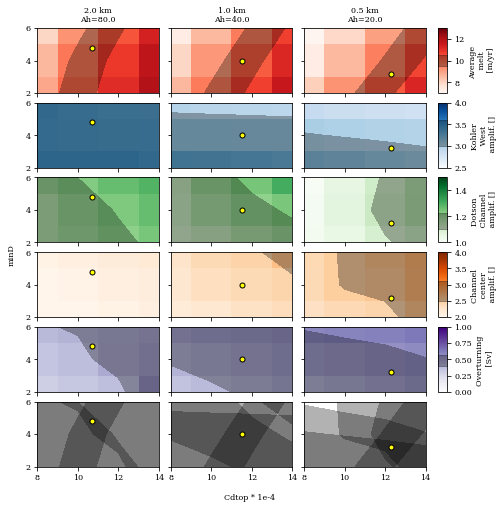

In [40]:
plt.style.use('style_paper')

mpl.rc('figure.subplot',left=.08,right=.85,top=.95,bottom=.08,wspace=.1,hspace=.15)

fig,ax = plt.subplots(Ndiags+1,len(ress),figsize=(7,7),sharex=True,sharey=True)
for r,res in enumerate(ress):
    
    Ah = Ahs[r]
    dx = res*1000
        
    MCD  = np.zeros((len(minds),len(cdtops)))
    MKW  = np.zeros((len(minds),len(cdtops)))
    OVER = np.zeros((len(minds),len(cdtops)))
    MDC  = np.zeros((len(minds),len(cdtops)))
    MCC  = np.zeros((len(minds),len(cdtops)))

    for m,minD in enumerate(minds):
        for c,Cdtop in enumerate(cdtops):
            ds = xr.open_dataset(f'../../results/tuning/{res:.1f}_{minD:.1f}_{Cdtop:.0f}_{mu:.1f}_{Ah:.0f}.nc')
            MCD[m,c],MKW[m,c],MDC[m,c],OVER[m,c] = getdiags(ds)
            MCC[m,c] = getdisc2(ds)
            ds.close()

    diag = {}
    diag[0] = Diag(MCD,7,13,9.5,10.5,'k','Reds','Average \n melt \n [m/yr]')
    diag[1] = Diag(MKW/MCD,2.5,4,3,3.6,'k','Blues','Kohler \n West \n amplif. []')
    diag[2] = Diag(MDC/MCD,1,1.5,1.1,1.23,'k','Greens','Dotson \n Channel \n amplif. []')
    diag[3] = Diag(MCC/MCD,2,4,2.5,3.1,'k','Oranges','Channel \n center \n amplif. []')
    diag[4] = Diag(OVER,0,1,.40,.57,'k','Purples','Overturning \n [Sv]')
    
    
    for d in range(Ndiags):
        im = diag[d].plot(ax[d,r])
        if r==len(ress)-1:
            dax = fig.add_subplot(Ndiags+1,len(ress),len(ress)*(d+1))
            dax.set_visible(False)
            axins = inset_axes(dax,width="8%",height="100%",loc='lower left',bbox_to_anchor=(1.1, 0, 1, 1),bbox_transform=dax.transAxes,borderpad=0)
            cbar = plt.colorbar(im, cax=axins,label=diag[d].label)
            cbar.ax.fill_between([0,20],[diag[d].tmin,diag[d].tmin],[diag[d].tmax,diag[d].tmax],color=diag[d].color,alpha=.3)    

        ax[Ndiags,r].contourf(cdtops,minds,diag[d].values,[diag[d].tmin,diag[d].tmax],alpha=.3,colors=diag[d].color)
        
    for d in range(Ndiags+1):    
        ax[d,r].set_ylim([minds[0],minds[-1]])
        ax[d,r].set_yticks(minds)
        
    ax[0,r].set_title(f'{res:.1f} km\nAh={Ah:.1f}')

for i in range(Ndiags+1):
    ax[i,0].scatter(10.7,4.8,25,c='yellow',edgecolor='k')
    ax[i,1].scatter(11.5,4,25,c='yellow',edgecolor='k')
    ax[i,2].scatter(12.3,3.2,25,c='yellow',edgecolor='k')

ax[0,0].set_xlim([cdtops[0],cdtops[-1]])
ax[0,0].set_xticks(cdtops)
fig.supxlabel('Cdtop * 1e-4')
fig.supylabel('minD')

plt.savefig('../../figures/draftplot_tuning.png',dpi=450)

8.150892202904194 1.172790245022186
19.603049179603314 2.820582615770261 2.4050188239047836


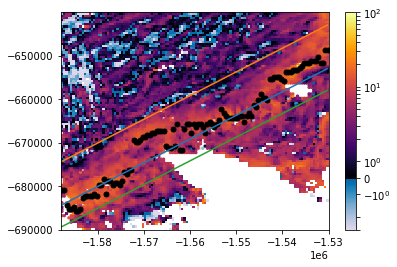

In [106]:
x1,x2,y1,y2=-1.588e6,-1.530e6,-690000,-640000
dss = xr.open_dataset('../../../data/gourmelen/CrossonDotson.nc')

dx = 500

dss = dss.sel(x=slice(x1,x2),y=slice(y1,y2))
melt = dss.Band1.values

xarr = dss.x.values
yarr = dss.y.values

a = 5.45e-01
b = 1.81e5
bplus = 10000
bmin = 5000

Nvals = int((bplus+bmin)/dx)
ymin = a*xarr+b-bmin
ymax = a*xarr+b+bplus

mmelt = np.zeros((Nvals,len(xarr)))
yval  = np.zeros((Nvals,len(xarr)))
for i,ii in enumerate(xarr):
    yidx = np.argmin((yarr-ymin[i])**2)
    yval[:,i] = yarr[yidx:yidx+Nvals]
    mmelt[:,i] = melt[yidx:yidx+Nvals,i]

mdc = np.nanmean(mmelt)
print(mdc,mdc/6.95)

plt.plot(xarr,a*xarr+b)
plt.plot(xarr,a*xarr+b+bplus)
plt.plot(xarr,a*xarr+b-bmin)
plotmelt(dss,melt)
for i in range(Nvals):
    plt.scatter(xarr,yval[i,:],5,c=mmelt[i,:],cmap=mymap,norm=mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax, linscale=linscale))

x1,x2,y1,y2=-1.588e6,-1.530e6,-690000,-645000
dss = dss.sel(x=slice(x1,x2),y=slice(y1,y2))
melt = dss.Band1

xarr = dss.x.values
yarr = dss.y.values
mmax = 0*xarr
yval = 0*xarr
for i,ii in enumerate(xarr):
    yidx = np.argmin((yarr-ymin[i])**2)
    mmelt = melt[yidx:yidx+Nvals,i]
    yyarr = yarr[yidx:yidx+Nvals]
    mmax[i]=np.nanmax(mmelt)
    yval[i]=yyarr[np.nanargmax(mmelt)]
MCC = np.nanmean(mmax)
print(MCC,MCC/6.95,MCC/mdc)
plt.scatter(xarr,yval,25,c='k')
#print(np.nanmean(mmax),np.nanmean(mmax)/6.95)
#melt = dss.Band1.values
#melt = np.where(melt<0,np.nan,melt)

#

#xarr = dss.x.sel(slice(x1,x2))

10.21 3.38 1.15 1.99 0.38 1.73


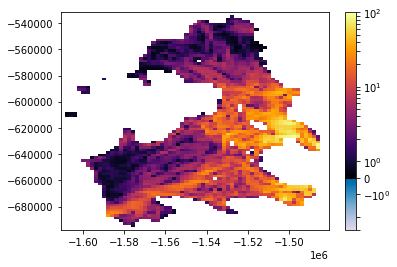

In [134]:
res = 2
dx = res*1000
minD = 4
Cdtop = 10
mu = .5
Ah = 60

ds = xr.open_dataset(f'../../results/tuning/{res:.1f}_{minD:.1f}_{Cdtop:.0f}_{mu:.1f}_{Ah:.0f}.nc')
MCD,MKW,MDC,OVER = getdiags(ds)
plotmelt(ds,np.where(ds.tmask,ds.melt,np.nan))
MCC = getdisc2(ds)
ds.close()
print(f'{MCD:.2f} {MKW/MCD:.2f} {MDC/MCD:.2f} {MCC/MCD:.2f} {OVER:.2f} {MCC/MDC:.2f}')


9.77 3.09 1.16 2.35 0.48 2.02


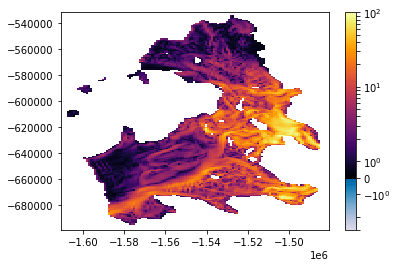

In [133]:
res = 1
dx = res*1000
minD = 4
Cdtop = 10
mu = .5
Ah = 30

ds = xr.open_dataset(f'../../results/tuning/{res:.1f}_{minD:.1f}_{Cdtop:.0f}_{mu:.1f}_{Ah:.0f}.nc')
MCD,MKW,MDC,OVER = getdiags(ds)
plotmelt(ds,np.where(ds.tmask,ds.melt,np.nan))
MCC = getdisc2(ds)
ds.close()
print(f'{MCD:.2f} {MKW/MCD:.2f} {MDC/MCD:.2f} {MCC/MCD:.2f} {OVER:.2f} {MCC/MDC:.2f}')

9.43 3.06 1.08 2.51 0.49 2.32


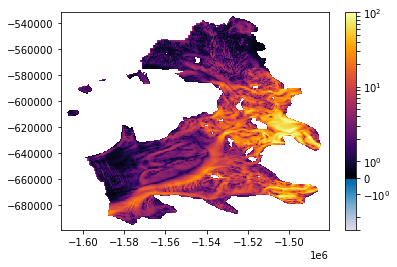

In [152]:
res = .5
dx = res*1000
minD = 3
Cdtop = 11
mu = 2.5
Ah = 20

ds = xr.open_dataset(f'../../results/tuning/{res:.1f}_{minD:.1f}_{Cdtop:.0f}_{mu:.1f}_{Ah:.0f}.nc')
MCD,MKW,MDC,OVER = getdiags(ds)
plotmelt(ds,np.where(ds.tmask,ds.melt,np.nan))
MCC = getdisc2(ds)
ds.close()
print(f'{MCD:.2f} {MKW/MCD:.2f} {MDC/MCD:.2f} {MCC/MCD:.2f} {OVER:.2f} {MCC/MDC:.2f}')